# VGG16_ImageNet

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from tensorflow import keras
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=(224,224,3)
                  )
base_model.summary()

Metal device set to: Apple M2


2023-03-19 14:28:17.761281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-19 14:28:17.761367: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
from keras.layers import Dense, Flatten

last_layer = base_model.get_layer('block5_pool') # 마지막층에 접근
last_output = last_layer.output # 마지막 층의 출력을 다음 층의 입력으로

x = Flatten()(last_output)
x = Dense(5, activation='softmax', name='softmax')(x)

In [5]:
new_model = keras.Model(inputs=base_model.input, outputs=x)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

data_files = os.path.join(os.getcwd(),'transfer_lr_data_files')

train_imgs = np.load(data_files+'/target_images.npy')
train_labels = np.load(data_files+'/target_labels.npy')

test_imgs = np.load(data_files+'/test_images.npy')
test_labels = np.load(data_files+'/test_labels.npy')

print(train_imgs.shape)
print(train_labels[0])

(65, 224, 224, 3)
[1. 0. 0. 0. 0.]


In [7]:
Dict = ['Hat', 'Cube', 'Card', 'Torch', 'screw']

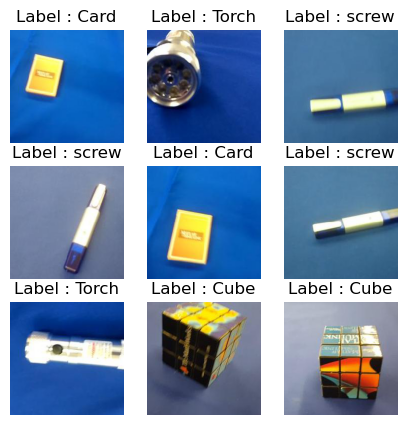

In [8]:
n_train = train_imgs.shape[0]
n_test = test_imgs.shape[0]
idx = np.random.randint(0, n_train, size=9)
images = train_imgs[idx]
labels = train_labels[idx]

plt.figure(figsize=(5,5))
for i in range(len(idx)):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.title("Label : {}".format(Dict[np.argmax(labels[i])]))
plt.show()

In [9]:
%load_ext tensorboard

In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import math

# Model Checkpoints
model_name = 'transfer_lr.{epoch:02d}.h5'
filepath1 = os.path.join(os.getcwd(), 'transfer_lr')
if not os.path.isdir(filepath1):
    os.makedirs(filepath1)
    
filepath2 = os.path.join(filepath1, model_name)
checkpoints = ModelCheckpoint(filepath=filepath2,
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True
                             )

# Model lr_scheduler setting
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = LearningRateScheduler(decay)

sgd = keras.optimizers.SGD(learning_rate=initial_lrate, momentum=0.9, nesterov=False)

# Tensorboard
log_dir = 'log'
filepath3 = os.path.join(filepath1, log_dir)
tensorboard_cb = keras.callbacks.TensorBoard(filepath3, histogram_freq=1)

# Compile and training
batch_size = 20
epochs = 50

new_model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy']
                 )

hist = new_model.fit(train_imgs, train_labels, batch_size=batch_size, epochs=epochs,
                     validation_data=(test_imgs, test_labels), 
                     callbacks=[checkpoints, lr_scheduler, tensorboard_cb],
                     verbose=2,
                     shuffle=True
                    )

Epoch 1/50


2023-03-19 14:28:26.847858: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-19 14:28:27.115284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-19 14:28:28.223378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.11111, saving model to /Users/jaehwan/Desktop/Git/Artificial-Intelligence/DeepLearning/CV_Model/transfer_lr/transfer_lr.01.h5
4/4 - 3s - loss: 8.6578 - accuracy: 0.2462 - val_loss: 70.6759 - val_accuracy: 0.1111 - lr: 0.0100 - 3s/epoch - 642ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.11111 to 0.55556, saving model to /Users/jaehwan/Desktop/Git/Artificial-Intelligence/DeepLearning/CV_Model/transfer_lr/transfer_lr.02.h5
4/4 - 2s - loss: 55.8064 - accuracy: 0.2462 - val_loss: 17.3733 - val_accuracy: 0.5556 - lr: 0.0100 - 2s/epoch - 480ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.55556 to 0.66667, saving model to /Users/jaehwan/Desktop/Git/Artificial-Intelligence/DeepLearning/CV_Model/transfer_lr/transfer_lr.03.h5
4/4 - 2s - loss: 37.7956 - accuracy: 0.2923 - val_loss: 33.4454 - val_accuracy: 0.6667 - lr: 0.0100 - 2s/epoch - 539ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.66667
4/4 - 2s - loss: 53

Epoch 41/50

Epoch 41: val_accuracy did not improve from 1.00000
4/4 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0085 - 2s/epoch - 447ms/step
Epoch 42/50

Epoch 42: val_accuracy did not improve from 1.00000
4/4 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0085 - 2s/epoch - 444ms/step
Epoch 43/50

Epoch 43: val_accuracy did not improve from 1.00000
4/4 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0085 - 2s/epoch - 438ms/step
Epoch 44/50

Epoch 44: val_accuracy did not improve from 1.00000
4/4 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0085 - 2s/epoch - 463ms/step
Epoch 45/50

Epoch 45: val_accuracy did not improve from 1.00000
4/4 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0085 - 2s/epoch - 456ms/step
Epoch 46/50

Epoch 46: va

In [12]:
%tensorboard --logdir $filepath3

# Fine_Tuning

In [13]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [41]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
import os

In [42]:
model = VGG16(weights="imagenet", include_top=True, input_shape=(224,224,3))

In [64]:
image = load_img(os.path.join(os.getcwd(), 'transfer_lr_data_files/image.jpeg'), target_size=(224,224))
image = img_to_array(image)

In [65]:
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# image = image.astype('float32')/255
image = preprocess_input(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


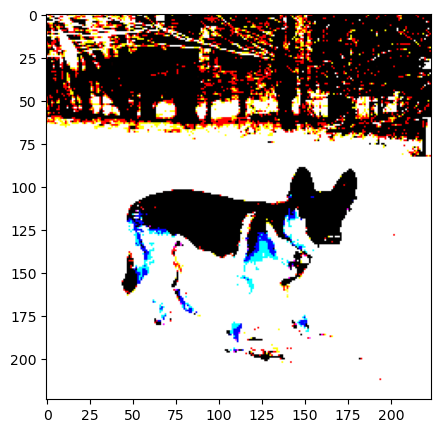

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.imshow(image[0], cmap='gray')

In [69]:
yhat = model.predict(image)
label = decode_predictions(yhat)
label = label[0][0]
print('%s (%.2f%%)'%(label[1],label[2]*100))

German_shepherd (96.73%)
